# NLP 특강
---

- 허깅 페이스 트랜스포머 모델과 토크나이저를 불러와본다.

In [1]:
!pip install -q datasets transformers torch tqdm tensorboard

- 토치, 자동 분류 모델, 자동 토큰화 모듈을 가져온다.

In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

c:\Users\kss34\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceC

- 데이터셋을 가져온다.

In [3]:
from datasets import load_dataset

dataset = load_dataset("nsmc")

Found cached dataset nsmc (C:/Users/kss34/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)
100%|██████████| 2/2 [00:00<00:00, 59.81it/s]


- 학습을 위해 숫자를 텐서로 변환한다.

In [4]:
dataset = dataset.with_format("torch")

print(dataset['train'][0])

{'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': tensor(0)}


- 필요한 패키지를 불러오고 데이터셋을 확인해본다.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 확인
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

- 데이터프레임을 정의한다.

In [6]:
df = pd.DataFrame(dataset['train'])

print('데이터프레임 크기 :',df.shape)
df.tail()

데이터프레임 크기 : (150000, 3)


,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,tensor(0)
149996,8549745,평점이 너무 낮아서...,tensor(1)
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,tensor(0)
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,tensor(1)
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,tensor(0)


In [7]:
# document 길이의 컬럼 생성 (length)
df['length'] = df['document'].apply(lambda X: len(X))

# Postive/Negative 라벨 생성
def pn(X):
    if X == 0:
        return 'Positive'
    else:
        return 'Negative'

df['label_2'] = df['label'].apply(pn)

df.tail()

,id,document,label,length,label_2
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,tensor(0),19,Positive
149996,8549745,평점이 너무 낮아서...,tensor(1),13,Negative
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,tensor(0),31,Positive
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,tensor(1),27,Negative
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,tensor(0),24,Positive


- 데이터프레임의 개요를 출력해본다.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  object
 1   document  150000 non-null  object
 2   label     150000 non-null  object
 3   length    150000 non-null  int64 
 4   label_2   150000 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.7+ MB


- Positive / Negative 개수를 출력해본다.

In [9]:
df['label_2'].value_counts()

label_2
Positive    75173
Negative    74827
Name: count, dtype: int64

In [10]:
df['length'].describe()

count    150000.000000
mean         35.203353
std          29.532097
min           0.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: length, dtype: float64

- 결측치를 확인해본다.

In [11]:
df.isnull().sum()

id          0
document    0
label       0
length      0
label_2     0
dtype: int64

- 분석한 내용을 시각화 해본다.

<Axes: >

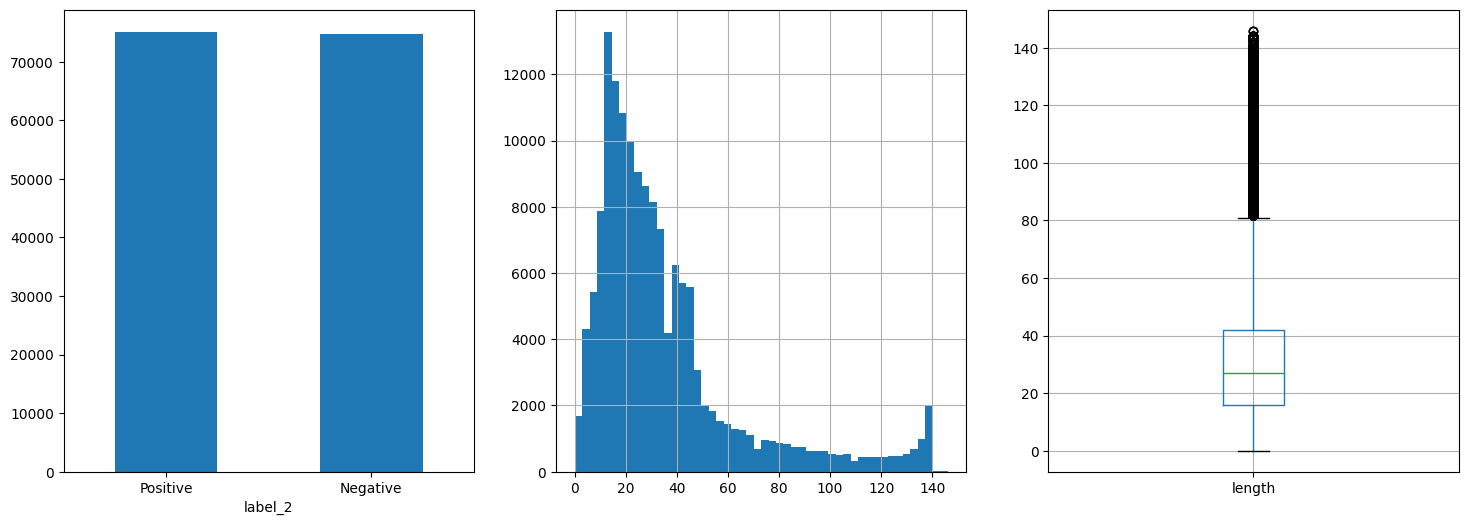

In [12]:
plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1)
df['label_2'].value_counts().plot.bar()
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
df['length'].hist(bins=50)

plt.subplot(1, 3, 3)
df.boxplot(column=['length'])

- 이제 본격적으로 토크나이저 실습을 진행해보자.

- 다음은 토크나이저의 사용 예이다.

In [13]:
inputs = tokenizer(dataset['train'][0]['document'])

print('tokenizer output key:', inputs.keys())
print('input text:',dataset['train'][0]['document'])
print('tokenizer encoding(input_ids):', inputs['input_ids'])

decode_inputs = tokenizer.decode(inputs['input_ids'])
print('tokenizer decoding:', decode_inputs)

tokenizer output key: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input text: 아 더빙.. 진짜 짜증나네요 목소리
tokenizer encoding(input_ids): [2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3]
tokenizer decoding: [CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]


- 빠른 학습 및 검증을 위해 데이터셋 양을 줄여본다.

In [14]:
train_dataset = dataset['train'].select(range(10000))
valid_dataset = dataset['test'].select(range(1000))

- 데이터 로더를 정의해본다.

In [15]:
from torch.utils.data import DataLoader

train_batch_size = 32
valid_batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)

> CUDA를 설치한다.

- CUDA 설치와 관련된 내용은 [이곳](https://hyunsooworld.tistory.com/entry/AssertionError-Torch-not-compiled-with-CUDA-enabled)을 참고한다.

In [ ]:
!nvidia-smi

In [ ]:
import tensorflow as tf

print(tf.__version__)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
import tensorflow
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
import torch

print(torch.cuda.is_available())

---

- 모델을 추론해본다.

In [ ]:
model.to('cuda')
model.eval()

test_index = 0
test_data = dataset['test'][test_index]
# test_text = test_data['document']

test_text = '킹 받는 영화'

inputs = tokenizer(test_text, return_tensors='pt').to(model.device)
with torch.no_grad():
  logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(test_data)
print('prediction:',predicted_class_id)

- 학습 전 검증을 해본다.

In [ ]:
from tqdm import tqdm

model.to('cuda')
model.eval()

before_ACCs=[]
for valid_batch in tqdm(valid_dataloader):

  inputs = tokenizer(valid_batch['document'], return_tensors='pt', padding=True).to(model.device)

  # print(inputs)
  with torch.no_grad():
    logits = model(**inputs).logits
  # print(logits)
  predicted_class_id = logits.argmax(dim=1).to('cpu')
  # print(predicted_class_id)
  # print(valid_batch['label'])
  acc=sum(predicted_class_id==valid_batch['label'])/len(valid_batch['label'])
  before_ACCs.append(acc)

print('')
print('valid ACC before training:',(sum(before_ACCs)/len(before_ACCs)*100).item(),'%')

- 토큰 수를 확인해본다.

In [ ]:
tokenizer.model_max_length

512

- 모델 학습 시각화를 위해 텐서 보드를 정의해본다.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/nsmc_experiment')

- 모델을 학습해본다.

In [ ]:
# model.to('cuda')
model.train()
learning_rate = 2e-4  
train_loss = 0.0
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loader = tqdm(train_dataloader)

for i, train_batch in enumerate(train_loader):
  inputs = tokenizer(train_batch['document'], return_tensors='pt', padding=True).to(model.device)
  labels = train_batch['label'].to(model.device)

  outputs = model(**inputs, labels=labels)
  loss = outputs[0]
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  train_loss += loss
  if i == 0:
    writer.add_scalar('train loss', train_loss, i)
  elif i% 10 == 0:
    writer.add_scalar('train loss', train_loss/10, i)
    train_loss = 0.0
  
  train_loader.set_description("train loss %.04f | step %d" % (loss, i))

- 학습한 것을 시각화해본다. (Train-Loss)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {'/content/runs'}

- 학습 후 검증을 해본다.

In [ ]:
model.eval()

after_ACCs=[]
for valid_batch in tqdm(valid_dataloader):
  inputs = tokenizer(valid_batch['document'], return_tensors='pt', padding=True).to(model.device)

  with torch.no_grad():
    logits = model(**inputs).logits

  predicted_class_id = logits.argmax(dim=1).to('cpu')
  acc=sum(predicted_class_id==valid_batch['label'])/len(valid_batch['label'])
  after_ACCs.append(acc)

print('')
print('valid ACC after training:',(sum(after_ACCs)/len(after_ACCs)*100).item(),'%')

- 모델을 테스트 해본다.

In [ ]:
test_text = '재밌더라'

model.eval()
print(f'input text:{test_text}')
inputs = tokenizer(test_text, return_tensors='pt').to(model.device)
with torch.no_grad():
  logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
if predicted_class_id == 0:
  print('분석 결과: 부정')
else:
  print('분석 결과: 긍정')

- 학습 모델을 저장해본다.

In [ ]:
torch.save(model.state_dict(), './model1')

- 다음과 같이 새 모델을 불러올 수 있다.

In [ ]:
import torch 
from transformers import AutoModelForSequenceClassification, AutoTokenizer

new_model = AutoModelForSequenceClassification_pretrained('klue/bert-base')